# SIRD Model

Basic SIRD model for Indonesia Covid 
(data until 20200327)

![SIRD](../images/Scheme-of-Susceptible-Infectious-Recovered-Death-SIRD-Model-Boxes-represent.png)

In [1]:
import pandas as pd
import scipy.integrate as spi
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

In [2]:
PATH_DATA = '../data/raw/'

In [3]:
## Assumption
NUMB_OF_POPS=200000000

## Get The Data

Getting the data and do the summary

In [4]:
df_daily=pd.read_csv(PATH_DATA+'20200327_DailyCase_ID.csv')
df_daily=df_daily.fillna(0)

In [5]:
df_daily

,DT,Kasus (Kumulatif),Kasus Baru,Sembuh (baru),Meninggal (baru)
0,2020-03-02 00:00:00,2,2.0,0.0,0.0
1,2020-03-03 00:00:00,2,0.0,0.0,0.0
2,2020-03-04 00:00:00,2,0.0,0.0,0.0
3,2020-03-05 00:00:00,2,0.0,0.0,0.0
4,2020-03-06 00:00:00,4,2.0,0.0,0.0
5,2020-03-07 00:00:00,4,0.0,0.0,0.0
6,2020-03-08 00:00:00,6,2.0,0.0,0.0
7,2020-03-09 00:00:00,19,13.0,0.0,0.0
8,2020-03-10 00:00:00,27,8.0,0.0,0.0
9,2020-03-11 00:00:00,34,7.0,2.0,2.0


In [6]:
df_daily['Rec']=df_daily['Sembuh (baru)'].cumsum()
df_daily['Dea']=df_daily['Meninggal (baru)'].cumsum()
df_daily['Inf']=df_daily['Kasus (Kumulatif)']-df_daily['Rec']-df_daily['Dea']
df_daily['Sus']=NUMB_OF_POPS-df_daily['Inf']-df_daily['Rec']-df_daily['Dea']

In [7]:
col_use=['Sus','Inf','Rec','Dea']

In [8]:
df_daily_sird=df_daily[col_use]/NUMB_OF_POPS

In [9]:
df_daily_sird

,Sus,Inf,Rec,Dea
0,1.000000,1.000000e-08,0.000000e+00,0.000000e+00
1,1.000000,1.000000e-08,0.000000e+00,0.000000e+00
2,1.000000,1.000000e-08,0.000000e+00,0.000000e+00
3,1.000000,1.000000e-08,0.000000e+00,0.000000e+00
4,1.000000,2.000000e-08,0.000000e+00,0.000000e+00
5,1.000000,2.000000e-08,0.000000e+00,0.000000e+00
6,1.000000,3.000000e-08,0.000000e+00,0.000000e+00
7,1.000000,9.500000e-08,0.000000e+00,0.000000e+00
8,1.000000,1.350000e-07,0.000000e+00,0.000000e+00
9,1.000000,1.500000e-07,1.000000e-08,1.000000e-08


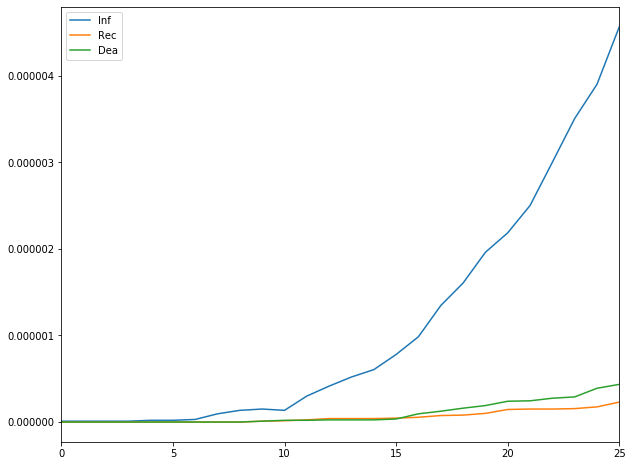

In [10]:
df_daily_sird[['Inf','Rec','Dea']].plot(figsize=(10,8))

## Define SIRD Model

![SIRD derivative funtion](../images/SIRD-Model.png)

In [11]:
def sird_model_diff(VALUE_ON_T,t):  
    '''The main set of equations'''
    Y=np.zeros((4))
    dS,dI,dR,dD = VALUE_ON_T  
    Y[0] = - param_b * dS * dI
    Y[1] = (param_b * dS * dI) - (param_r * dI) - (param_m * dI)
    Y[2] = param_r * dI
    Y[3] = param_m * dI
    
    return Y   # For odeint (ordinary differential equation)

## Determine the Parameter

using simple linear regression

In [12]:
df_daily_sird.head(10)

,Sus,Inf,Rec,Dea
0,1.0,1.000000e-08,0.000000e+00,0.000000e+00
1,1.0,1.000000e-08,0.000000e+00,0.000000e+00
2,1.0,1.000000e-08,0.000000e+00,0.000000e+00
3,1.0,1.000000e-08,0.000000e+00,0.000000e+00
4,1.0,2.000000e-08,0.000000e+00,0.000000e+00
5,1.0,2.000000e-08,0.000000e+00,0.000000e+00
6,1.0,3.000000e-08,0.000000e+00,0.000000e+00
7,1.0,9.500000e-08,0.000000e+00,0.000000e+00
8,1.0,1.350000e-07,0.000000e+00,0.000000e+00
9,1.0,1.500000e-07,1.000000e-08,1.000000e-08


In [13]:
for cc in col_use:
    df_daily_sird[cc+'_before']=df_daily_sird[cc].shift(1)
    df_daily_sird[cc+'_dt']=df_daily_sird[cc]-df_daily_sird[cc+'_before']

In [14]:
# df_daily_sird

In [15]:
col_use_t=['Sus_dt','Inf_dt','Rec_dt','Dea_dt']

In [16]:
df_daily_sird2=df_daily_sird[col_use+col_use_t].dropna()

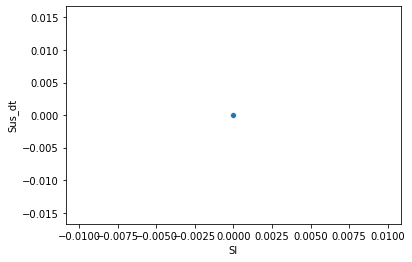

In [17]:
## param_b
# Y[0] = - param_b * dS * dI
df_daily_sird2['SI']=df_daily_sird2['Sus']*df_daily_sird2['Inf']
sns.scatterplot(data=df_daily_sird2[['Sus_dt','SI']],x='SI',y='Sus_dt')

In [19]:
param_b_df=df_daily_sird2[['Sus_dt','SI']]
param_b_df=param_b_df.dropna()
param_b_mod = sm.GLS(param_b_df['Sus_dt'],param_b_df['SI'])
param_b_res = param_b_mod.fit()
param_b_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 GLS Regression Results                                
=======================================================================================
Dep. Variable:                 Sus_dt   R-squared (uncentered):                   0.949
Model:                            GLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              445.4
Date:                Sat, 28 Mar 2020   Prob (F-statistic):                    5.26e-17
Time:                        10:20:06   Log-Likelihood:                          377.33
No. Observations:                  25   AIC:                                     -752.7
Df Residuals:                      24   BIC:                                     -751.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SI            -0.1633      0.008    -21.105      0.000      -0.179      -0.147
==============================================================================
Omnibus:                        2.892   Durbin-Watson:                   1.216
Prob(Omnibus):                  0.236   Jarque-Bera (JB):                1.376
Skew:                          -0.398   Prob(JB):                        0.502
Kurtosis:                       3.829   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.91e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [21]:
b0=abs(param_b_res.params['SI'])
range_param_b=param_b_res.conf_int(alpha=0.05, cols=None)
range_param_b=range_param_b.values[0]
param_b_max=abs(range_param_b[0])
param_b_min=abs(range_param_b[1])
param_b_pvalues=param_b_res.pvalues.values[0]

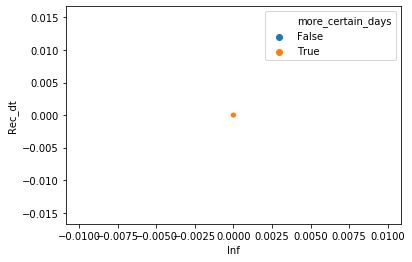

In [22]:
## param_r
# Y[2] = param_r * dI
df_daily_sird2['days']=[i for i in range(len(df_daily_sird2))]
df_daily_sird2['more_certain_days']=(df_daily_sird2['days']>3)
sns.scatterplot(data=df_daily_sird2[['Rec_dt','Inf','more_certain_days']],x='Inf',y='Rec_dt',hue='more_certain_days')

In [23]:
param_r_df=df_daily_sird2[df_daily_sird2.more_certain_days][['Rec_dt','Inf']]
param_r_mod = sm.GLS(param_r_df['Rec_dt'],param_r_df['Inf'])
param_r_res = param_r_mod.fit()
param_r_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 GLS Regression Results                                
=======================================================================================
Dep. Variable:                 Rec_dt   R-squared (uncentered):                   0.568
Model:                            GLS   Adj. R-squared (uncentered):              0.546
Method:                 Least Squares   F-statistic:                              26.25
Date:                Sat, 28 Mar 2020   Prob (F-statistic):                    5.17e-05
Time:                        10:20:36   Log-Likelihood:                          353.35
No. Observations:                  21   AIC:                                     -704.7
Df Residuals:                      20   BIC:                                     -703.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inf            0.0070      0.001      5.124      0.000       0.004       0.010
==============================================================================
Omnibus:                        1.439   Durbin-Watson:                   1.474
Prob(Omnibus):                  0.487   Jarque-Bera (JB):                0.442
Skew:                           0.313   Prob(JB):                        0.802
Kurtosis:                       3.337   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.91e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [24]:
r0=param_r_res.params['Inf']
range_param_r=param_r_res.conf_int(alpha=0.05, cols=None)
range_param_r=range_param_r.values[0]
param_r_max=range_param_r[1]
param_r_min=max(0,range_param_r[0])
param_r_pvalues=param_r_res.pvalues.values[0]

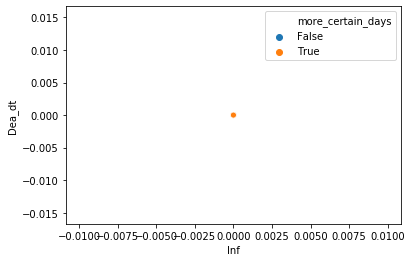

In [25]:
## param_m
# Y[3] = param_m * dI
sns.scatterplot(data=df_daily_sird2[['Dea_dt','Inf','more_certain_days']],x='Inf',y='Dea_dt',hue='more_certain_days')

In [26]:
param_m_df=df_daily_sird2[df_daily_sird2.more_certain_days][['Dea_dt','Inf']]
param_m_mod = sm.GLS(param_m_df['Dea_dt'],param_m_df['Inf'])
param_m_res = param_m_mod.fit()
param_m_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 GLS Regression Results                                
=======================================================================================
Dep. Variable:                 Dea_dt   R-squared (uncentered):                   0.660
Model:                            GLS   Adj. R-squared (uncentered):              0.643
Method:                 Least Squares   F-statistic:                              38.80
Date:                Sat, 28 Mar 2020   Prob (F-statistic):                    4.40e-06
Time:                        10:20:44   Log-Likelihood:                          343.40
No. Observations:                  21   AIC:                                     -684.8
Df Residuals:                      20   BIC:                                     -683.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inf            0.0137      0.002      6.229      0.000       0.009       0.018
==============================================================================
Omnibus:                        4.314   Durbin-Watson:                   2.323
Prob(Omnibus):                  0.116   Jarque-Bera (JB):                2.291
Skew:                           0.686   Prob(JB):                        0.318
Kurtosis:                       3.857   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.91e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [27]:
m0=param_m_res.params['Inf']
range_param_m=param_m_res.conf_int(alpha=0.05, cols=None)
range_param_m=range_param_m.values[0]
param_m_max=range_param_m[1]
param_m_min=max(0,range_param_m[0])
param_m_pvalues=param_m_res.pvalues.values[0]

In [28]:
range_param_r

array([0.00417104, 0.00989918])

In [29]:
range_param_m

array([0.00913541, 0.01833526])

In [30]:
range_param_b

array([-0.17924109, -0.14730797])

In [32]:
def targ_func(param_b,param_r,param_m,df=df_daily_sird2):
    N=1000000
    true_Sdt=df['Sus_dt']*N
    true_Idt=df['Inf_dt']*N
    
    pred_Sdt=(-param_b*df['Sus']*df['Inf'])*N
    pred_Rdt=(param_r*df['Inf'])*N
    pred_Ddt=(param_m*df['Dea'])*N
    pred_Idt=((param_b*df['Sus']*df['Inf'])*N)-pred_Rdt-pred_Ddt
    
    e1=((true_Sdt-pred_Sdt)**2).sum()*0.85
    e2=((true_Idt-pred_Idt)**2).sum()*0.15
    
    return -(e1+e2)


In [135]:
# Opt_Targ = BayesianOptimization(targ_func, {'param_b': (0.14730797, 0.17924109),'param_r': (0.00417104, 0.00989918),'param_m': (0.00913541, 0.01833526)})
Opt_Targ = BayesianOptimization(targ_func, {'param_b': (0.26, 0.29),'param_r': (0.00417104, 0.00989918),'param_m': (0.00913541, 0.01833526)})

In [136]:
## v1
# |   iter    |  target   |  param_b  |  param_m  |  param_r  |
# -------------------------------------------------------------
# |  53       | -0.4165   |  0.1754   |  0.01455  |  0.007979 |
# |  135      | -0.1393   |  0.1626   |  0.01896  |  0.01029  |

In [ ]:
Opt_Targ.maximize(init_points=30, n_iter=20)

|   iter    |  target   |  param_b  |  param_m  |  param_r  |
-------------------------------------------------------------
|  1        | -1.383    |  0.2884   |  0.009659 |  0.009674 |
|  2        | -1.088    |  0.2719   |  0.01645  |  0.004358 |
|  3        | -1.06     |  0.2703   |  0.01004  |  0.004763 |
|  4        | -1.012    |  0.2675   |  0.01499  |  0.00429  |
|  5        | -1.276    |  0.2821   |  0.0109   |  0.004457 |
|  6        | -1.397    |  0.2892   |  0.01682  |  0.009894 |
|  7        | -0.9812   |  0.2658   |  0.01199  |  0.005813 |
|  8        | -0.9882   |  0.2663   |  0.01201  |  0.005959 |
|  9        | -0.8999   |  0.2611   |  0.0176   |  0.007013 |
|  10       | -1.104    |  0.2728   |  0.01246  |  0.004321 |
|  11       | -1.374    |  0.2878   |  0.01695  |  0.007765 |
|  12       | -1.397    |  0.2889   |  0.01449  |  0.007779 |
|  13       | -1.123    |  0.274    |  0.01171  |  0.005248 |
|  14       | -1.243    |  0.2811   |  0.00989  |  0.009312 |
|  15   

In [37]:
b0,r0,m0

(0.16327453097814512, 0.007035109518407132, 0.013735334175600345)

In [129]:
# param_bo=0.1928
# param_ro=0.006604
# param_mo=0.4942

# param_bo=0.1784 
# param_ro=0.00655
# param_mo=0.1654

param_bo=0.1621 
param_ro=0.009834
param_mo=0.01832

param_bo=0.28
param_ro=0.009834
param_mo=0.01832

## Running SIRD Model

In [130]:
def sird_model_diff(VALUE_ON_T,t):  
    '''The main set of equations'''
    Y=np.zeros((4))
    dS,dI,dR,dD = VALUE_ON_T  
    Y[0] = - param_bo * dS * dI
    Y[1] = (param_bo * dS * dI) - (param_ro * dI) - (param_mo * dI)
    Y[2] = param_ro * dI
    Y[3] = param_mo * dI
    
    return Y   # For odeint

In [131]:
T_start = 0.0
T_inc=1.0
T_end=30*4
I0=2/NUMB_OF_POPS
S0=1-I0
INPUT = (S0, I0, 0.0, 0.0)

T_range = np.arange(T_start, T_end+T_inc, T_inc)
RES = spi.odeint(sird_model_diff,INPUT,T_range)

In [132]:
df_sird_pred=pd.DataFrame(RES,columns=['Sus','Inf','Rec','Dea'])

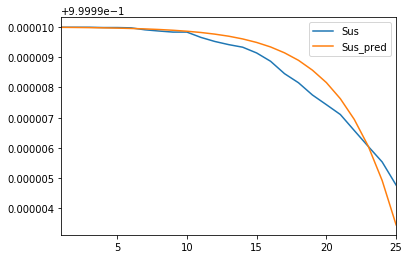

In [133]:
check_col='Sus'
col_use_pred=[x+'_pred' for x in col_use]
df_daily_sird2[col_use_pred]=df_sird_pred[1:len(df_daily_sird2)+1]
df_daily_sird2[[check_col,check_col+'_pred']].plot()

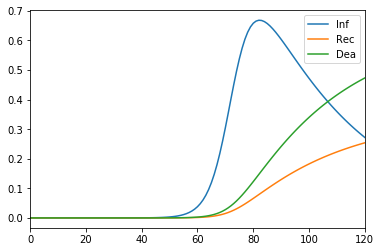

In [134]:
df_sird_pred[['Inf','Rec','Dea']].plot()
# df_sird_pred.plot(figsize=(10,8))

In [48]:
# df_sird_pred

In [77]:
# pd.DataFrame(RES,columns=['Sus','Inf','Rec','Dea'])

## Reference
    
    Data : https://kawalcovid19.blob.core.windows.net/viz/statistik_harian.html
    
    Source Script : http://epirecip.es/epicookbook/chapters/kr08/2_1/python_original
    
    Image 1 : https://www.researchgate.net/figure/Scheme-of-Susceptible-Infectious-Recovered-Death-SIRD-Model-Boxes-represent_fig1_41507287
    
    Image 2 : https://www.chegg.com/homework-help/questions-and-answers/codes-problem-code-1-function-siddeterm-simulation-deterministic-sird-model-using-differen-q21316613